In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objects as go
from pyvis.network import Network
import seaborn as sns

In [5]:
allall = pd.read_csv("../Datasets/Original/all-all_connectivity_matrix.csv")

Выбранные 20 нейронов: {'2628785', '8891315', '8711574', '14260575', '8069432', '4241237', '8069478', '4227544', '17867309', '10160250', '15588389', '8980589', '17591442', '3347708', '8066542', '10056280', '7690945', '1805418', '3587612', '5835799'}


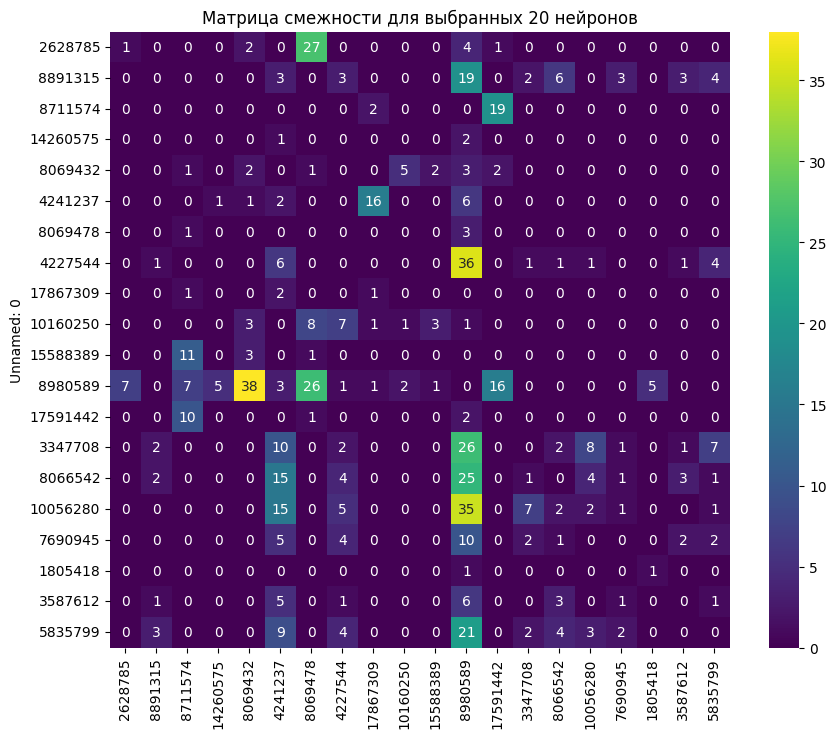

In [6]:
# подготовка матрицы
df = allall.set_index("Unnamed: 0")
df.index = df.index.astype(str)
df.columns = df.columns.astype(str)

# строим граф
G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)

# стартовая вершина = с наибольшим количеством связей
start = max(G.nodes, key=lambda n: G.in_degree(n, weight="weight") + G.out_degree(n, weight="weight"))

selected = {start}
queue = [start]

while len(selected) < 20 and queue:
    current = queue.pop(0)

    # все соседи (и входящие, и исходящие)
    neighbors = set(G.successors(current)) | set(G.predecessors(current))

    for nb in neighbors:
        if nb in selected:
            continue

        # условие: хотя бы одна двунаправленная связь с любым из выбранных
        valid = False
        for s in selected:
            if G.has_edge(nb, s) and G.has_edge(s, nb):
                valid = True
                break

        if valid:
            selected.add(nb)
            queue.append(nb)

        if len(selected) >= 20:
            break

print("Выбранные 20 нейронов:", selected)

# превращаем в список, сохраняя порядок обхода (по BFS)
selected_list = list(selected)

# вырезаем подматрицу смежности
submatrix = df.loc[selected_list, selected_list]

# рисуем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(submatrix, cmap="viridis", annot=True, fmt=".0f")
plt.title("Матрица смежности для выбранных 20 нейронов")
plt.show()


In [7]:
subG = G.subgraph(selected)

net = Network(
    notebook=True, 
    directed=True, 
    height="750px", 
    width="100%", 
    bgcolor="#ffffff", 
    font_color="black",
    cdn_resources="in_line"   # <── добавил
)

for node in subG.nodes():
    net.add_node(node, label=str(node), size=20, color="skyblue")

for u, v, d in subG.edges(data=True):
    w = d.get("weight", 1.0)
    net.add_edge(u, v, value=w, title=f"Вес: {w}", width=1 + w/5)

net.force_atlas_2based()

net.show("top20_neurons.html")

top20_neurons.html
